# Cohort creation

We define the cohorts for mortality prediction and length of stay prediction, based on the first 24 hour of stay of the patients.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

establish connection to DB and define helper function for running queries

In [2]:
import pandas as pd
from neoglia.etl.config import SSHInfoEicu, DBInfoEicu
from neoglia.etl.utils import connect_to_db_via_ssh, run_eicu_query, get_column_completeness, load_schema_for_modelling

conn = connect_to_db_via_ssh(SSHInfoEicu, DBInfoEicu)
cursor = conn.cursor()
query_schema = 'set search_path to eicu_crd;'

## Select the patients for mortality prediction

1. keep patients that are from the top 5 hospitals
2. keep visits that were at least 26 hours long
4. save unit stay ids as a new view

In [3]:
query = """
select  patientunitstayid, hospitalid, hosp_mort, region from icustay_detail
where hospitalid in (
    select distinct hospitalid  from patient_top5hospitals
    )
    and
    icu_los_hours >= 26
"""
df_patients = run_eicu_query(query, conn)

- We got 16.5k admissions in the largest 5 hospitals that fulfill this criteria. 
- The class inbalance seems to be roughly 1:10 in each.

In [4]:
df_patients.shape

(16567, 4)

In [5]:
df_patients.groupby(['hospitalid', 'hosp_mort'])['patientunitstayid'].count()

hospitalid  hosp_mort
73          0.0          4404
            1.0           373
167         0.0          2103
            1.0           243
176         0.0          1637
            1.0           122
264         0.0          3587
            1.0           358
420         0.0          3161
            1.0           469
Name: patientunitstayid, dtype: int64

The hospitals themselves are from different parts of the US

In [47]:
df_patients.groupby('hospitalid').first()['region']

hospitalid
73       Midwest
167         West
176         None
264      Midwest
420    Northeast
Name: region, dtype: object

Save these patients as a new view by executing `patient_top5hospitals_mort_dataset.sql`. 

# Feature creation

We want to be able to predict after 24 hour stay and at least 4 hours look forward if someone dies in a hospital.

1. get rid off everything that happened after the 24 hour for the cohort.
2. Create one liner features, i.e. which can be represented as a single row per patient.
    - gender,
    - age,
    - ethnicity,
    - height,
    - weight on admission
    - hospital region - embedded - 2
    - hospital unittype - embed - 2
    - apache_groups - embedded - 3
    - apacheapsvars - [imputed](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)
    - apachepredvars - imputed (same as above)
    - labsfirstday - imputed
    - diagnoses - embedded and averaged
3. Create time bucketed features. Here we deal with missing values by carrying forward the previous measurement, or in case of the first measurement, carrying that all the way back to the admission time.
    - pivoted_lab - bucketed to 24 hours
    - pivoted_bg - bucketed to 24 hours
    - pivoted_med - bucketed to 24 hours
    - pivotted_o2 - bucketed to 24 hours
    - pivotted_score - bucketed to 24 hours
    - pivotted_uo - bucketed to 24 hours
    - pivotted_vital - bucketed to 24 hours
    - pivotted_vital_other - bucketed to 24 hours

In [232]:
def get_table_completeness(table):
    """
    Quick helper that return column completeness for a table. 
    Note, it join on patients we're interested in for mortality
    pred and restricts for the first 24 hours.
    """
    
    query = """
    select * from %s l 
    join patient_top5hospitals_mort_dataset p 
    on l.patientunitstayid=p.patientunitstayid 
    where chartoffset < 1440
    """ % table
    df = run_eicu_query(query, conn)
    return (1-df.isnull().sum(axis=0)/df.shape[0])*100

In [34]:
get_table_completeness('pivoted_o2')

patientunitstayid    100.000000
chartoffset          100.000000
entryoffset          100.000000
o2_flow               41.555433
o2_device             70.856865
etco2                  1.263903
patientunitstayid    100.000000
hosp_mort             99.665268
dtype: float64

## Create one row per patient features

Start with the basic stay level variables

In [3]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [62]:
query = """
select
       i.patientunitstayid,
       admissionheight,
       admissionweight,
       ethnicity,
       region as hospital_region,
       unittype,
       apachedxgroup
from (select patientunitstayid from patient_top5hospitals_mort_dataset) p
join icustay_detail i
on p.patientunitstayid=i.patientunitstayid
join apache_groups ag
on p.patientunitstayid=ag.patientunitstayid
"""
df_basic = run_eicu_query(query, conn)

In [63]:
# add vars to numerical and non-numerical lists
num_vars = [
    'admissionheight',
    'admissionweight',
]
cat_vars = [
    'ethnicity',
    'hospital_region',
    'unittype',
    'apachedxgroup'
]

### Now add the more numerous apache and lab vars

In [64]:
query = """
select *
from (select patientunitstayid from patient_top5hospitals_mort_dataset) p
left join apacheapsvar a1
on p.patientunitstayid=a1.patientunitstayid
left join apachepredvar a2
on p.patientunitstayid=a2.patientunitstayid
left join labsfirstday l
on p.patientunitstayid=l.patientunitstayid
"""
df_apache_labs = run_eicu_query(query, conn)
# get rid off duplicated unitstayid cols
df_apache_labs = df_apache_labs.loc[:,~df_apache_labs.columns.duplicated()]

In [65]:
# add numeric cols to the num vars
float_cols = df_apache_labs.dtypes == 'float64'
non_id_cols = ~df_apache_labs.columns.str.endswith('id')
num_vars += list(df_apache_labs.columns[(float_cols & non_id_cols).ravel()].values)

Merge apache_lab and basic tables

In [66]:
df_basic_apache_labs = df_basic.set_index('patientunitstayid').join(df_apache_labs.set_index('patientunitstayid'))

#### Impute missing values 
Both for categorical vars (simple mode), and numerical vars (multivariate imputation)

In [75]:
df = df_basic_apache_labs

# make age numerical by replacing > 89 with 90
df.age[df.age.isnull()] = 90
df.age = df.age.astype(np.int)

# Impute categorical missing data in the simples way
imp = SimpleImputer(strategy="most_frequent")
df[cat_vars] = imp.fit_transform(df[cat_vars].astype('category'))

In [76]:
# Impute missing values for numerical variables too using iterative imputer
imp = IterativeImputer()
df[num_vars] = imp.fit_transform(df[num_vars].values)

In [84]:
# Save features so far
df[cat_vars + num_vars].to_csv('orpp_apache_lab_vars.csv')

### Add diagnosis features

Preprocess embeddings

In [128]:
from pathlib import Path
w2v_dir = Path('/home/danielhomola/Work/pa/pa_data/data')
embedding = w2v_dir / 'epi_dl_poc_vecs_w2v_icd_vs100_np600_mi10_lr05.csv'

In [204]:
# load embedding
df_emb = pd.read_csv(embedding, index_col=0)
# turn string vector into numerical vector
df_emb.insert(2, 'vector_num', df_emb.vector.apply(lambda x: [float(n) for n in x[1:-1].split(',')]))

In [205]:
# filter out icd 9 and 10s - get rid off string vector col
df_icd9 = df_emb[df_emb.word.str.startswith('d_1')][['word', 'vector_num']]
df_icd10 = df_emb[df_emb.word.str.startswith('d_2')][['word', 'vector_num']]

# delete d_1 and d_2 prefixes 
df_icd9.word = df_icd9.word.str.replace('d_1_', '')
df_icd10.word = df_icd10.word.str.replace('d_2_', '')

# some of the rare codes never converged during training and have huge norms.. let's discard them
def delete_large_vecs(df, thresh=1e27):
    df_filtered = df[df.vector_num.apply(np.linalg.norm) <= thresh]
    filtered_out = df[df.vector_num.apply(np.linalg.norm) > thresh].word
    return df_filtered, filtered_out

# make sure that we have the codes in the right format
df_icd9.word = df_icd9.word.str.replace('.', '').str.upper()
df_icd10.word = df_icd10.word.str.replace('.', '').str.upper()

# blow up the vector_num column into a 100 pandas columns so we can easily calculate the mean across them
emb_dim = 100
emb_cols = ["d%d" % x for x in range(emb_dim)]
df_icd9[emb_cols] = pd.DataFrame(df_icd9.vector_num.values.tolist(), index=df_icd9.index)
df_icd10[emb_cols] = pd.DataFrame(df_icd10.vector_num.values.tolist(), index=df_icd10.index)

If we want to filter out vectors whose norm is too big (i.e. that presumably didn't converge during the training) use this

In [202]:
# print('Prefiltered icd9: ', df_icd9.shape[0])
# df_icd9, filtered_out_icd9 = delete_large_vecs(df_icd9)
# print('Filtered icd9: ', df_icd9.shape[0])
# print('Prefiltered icd10: ', df_icd10.shape[0])
# df_icd10, filtered_out_icd10 = delete_large_vecs(df_icd10)
# print('Filtered icd10: ', df_icd10.shape[0])

# Use this to check the pre-filtering dist
# df_icd10.vector_num.apply(np.linalg.norm).hist(bins=50)

#### Get diagnosis vecs for patients

For each patient, take out the diag codes from the first 24 hours. 
- If we more than one code per visit we average them. 

In [207]:
query = """
select d.patientunitstayid, icd9code
from patient_top5hospitals_mort_dataset p
inner join diagnosis d
on p.patientunitstayid=d.patientunitstayid
where diagnosisoffset <= 1440 and icd9code notnull and icd9code != ''
"""
df_diag = run_eicu_query(query, conn)

In [208]:
# on average we get 9 diags per patient
df_diag.shape

(146303, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f927c37ef60>]],
      dtype=object)

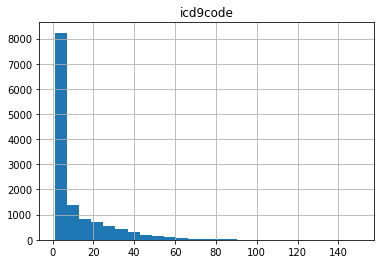

In [209]:
# check distribution of number of diags in the first 24 hours
df_diag.groupby('patientunitstayid').count().hist(bins=25)

#### Process ICD codes from ICU table

- Replace dots in ICD codes and capitalize codes, them up into two cols (ICD9 first, ICD10 second)
- Only keep the first 4 characters
- In roughly 2.5% of cases there are more than two codes. We'll treat these the same and ignore the remaining ones for simplicity's sake.


In [210]:
df_icu_icd9_10 = df_diag.icd9code\
    .str.replace('.', '')\
    .str.upper()\
    .str.split(',', expand=True)\
    .iloc[:, :2]\
    .apply(lambda x: x.str.strip().str.slice(0, 4))

df_icu_icd9_10.columns = ['icd9', 'icd10']
df_diag = pd.concat([df_diag, df_icu_icd9_10], axis=1)

#### Further process embedding vectors

After a lot of investigation, I found that from the 1400 ICD9 and ICD10 codes for these patients we only find about 250 in our embeddigs. So we quite aggressively we trim all codes longer than 4 chars to length of four, which brings up the matches to 600 out of 1200 unique codes. 

To make this work, in the embeddings we average all vectors that have the same four letter code. Note, this is sensible as ICD codes are hierarchical, each digit/letter going deeper in terms of granularity.

In [211]:
# shorten all embeddings to 4 chars too and average the corresponding embeddings
df_icd9_4 = df_icd9.copy()
df_icd10_4 = df_icd10.copy()
df_icd9_4.word = df_icd9_4.word.str.slice(0, 4)
df_icd10_4.word = df_icd10_4.word.str.slice(0, 4)
df_icd9_4.set_index('word', inplace=True)
df_icd10_4.set_index('word', inplace=True)

#### Check how many of the ICD codes we've got embedding for

Ok now we have pretty good coverage and the only ones we miss are 3 letter ICDs as we ignored these in our embeddings.

In [212]:
emb_icd9 = set(df_icd9_4.index.values)
emb_icd10 = set(df_icd10_4.index.values)
icu_icd9 = set(df_diag.icd9.values)
icu_icd10 = set(df_diag.icd10.values)

emb_icds = emb_icd9.union(emb_icd10)
icu_icds = icu_icd9.union(icu_icd10)
print('total ICU icds: ', len(icu_icds))
print('ICU icds we have embeddings for: ', len(emb_icds.intersection(icu_icds)))

total ICU icds:  1178
ICU icds we have embeddings for:  1117


#### Map icds in ICU stay to embedding vectors and average them across a single stay

In [213]:
df_icd9_mapped = df_diag.set_index('icd9').join(df_icd9_4, how='inner')
df_icd10_mapped = df_diag.set_index('icd10').join(df_icd10_4, how='inner')

In [217]:
# merge mapped icd9 and icd10 tables
df_diag_mapped = pd.concat([df_icd9_mapped, df_icd10_mapped])
df_diag_mapped.index = df_diag_mapped.index.set_names(['code'])
df_diag_mapped.reset_index(inplace=True)

In [220]:
df_diag_avg = df_diag_mapped.groupby('patientunitstayid')[emb_cols].mean()
df_diag_avg.to_csv('orpp_avg_diag.csv')

#### Load the other features and add these columns

In [228]:
df = pd.read_csv('orpp_apache_lab_vars.csv')
df = df.set_index('patientunitstayid').join(df_diag_avg, how='left').fillna(0)

In [230]:
df.to_csv('orpp_all.csv')

## Create time bucketed featers

Here we deal with missing values by carrying forward the previous measurement, or in case of the first measurement, carrying that all the way back to the admission time.
    - pivoted_lab - bucketed to 24 hours
    - pivoted_bg - bucketed to 24 hours
    - pivoted_med - bucketed to 24 hours
    - pivotted_o2 - bucketed to 24 hours
    - pivotted_score - bucketed to 24 hours
    - pivotted_uo - bucketed to 24 hours
    - pivotted_vital - bucketed to 24 hours
    - pivotted_vital_other - bucketed to 24 hours